# Tests for Energy Drifts

While the system is supposed to be Hamiltonian, it is possible that imprecise numeric calcualtions slowly drift the energy. The goal of this notebook is to check that. 

In [4]:
from double_pendulum_path_gen import *

initial_conditions = generate_initial_conditions(120, 5, PendulumParams)


In [6]:
normalized_state = normalize_init_state(initial_conditions[0])
t, traj = integrate_trajectory(PendulumParams, normalized_state)
angles = traj[:, [0, 2]]
angles = ((angles + np.pi) % (2 * np.pi)) - np.pi  # wrap to [-pi, pi]


In [11]:
print(initial_conditions[0])
print(normalized_state)
print(traj[0])
print(traj[1])

(243.59239013419128, -3.375783501412795, 112.31328682183869, -4.9769686992278865)
(243.59239013419128, -3.375783501412795, 112.31328682183869, -4.9769686992278865)
[ 4.25148924 -0.05891854  1.96023665 -0.08686449]
[ 4.25108475 -0.02198649  1.95926328 -0.10781938]


In [13]:
import numpy as np

def add_energy_column(traj: np.ndarray, params: PendulumParams) -> np.ndarray:
    """
    Given a trajectory array of shape (N, 4) containing
    [theta1, w1, theta2, w2] in radians and radians/sec,
    compute the total mechanical energy at each time point
    and return an array of shape (N, 5) where the last column is energy.
    """

    theta1 = traj[:, 0]
    w1     = traj[:, 1]
    theta2 = traj[:, 2]
    w2     = traj[:, 3]

    m1, m2 = params.M1, params.M2
    l1, l2 = params.L1, params.L2
    g      = params.G

    # --- Kinetic energy ---
    # Velocity of mass 1:
    # v1^2 = (l1*w1)^2
    T1 = 0.5 * m1 * (l1**2) * (w1**2)

    # Velocity of mass 2:
    # v2^2 = (l1*w1)^2 + (l2*w2)^2 + 2*l1*l2*w1*w2*cos(theta1 - theta2)
    T2 = 0.5 * m2 * (
        (l1**2)*(w1**2)
        + (l2**2)*(w2**2)
        + 2*l1*l2*w1*w2*np.cos(theta1 - theta2)
    )

    # --- Potential energy ---
    # y1 = -l1*cos(theta1)
    # y2 = y1 - l2*cos(theta2)
    # V = m*g*y
    V1 = m1 * g * (-l1 * np.cos(theta1))
    V2 = m2 * g * (-l1 * np.cos(theta1) - l2 * np.cos(theta2))

    # Total energy = kinetic + potential
    E = T1 + T2 + V1 + V2

    # Append as a new column
    traj_with_energy = np.hstack([traj, E[:, None]])
    return traj_with_energy

traj_energy = add_energy_column(traj, PendulumParams)

print(traj_energy.shape)   # (N, 5)
print(traj_energy[0])      # [theta1, w1, theta2, w2, E]

(100002, 5)
[ 4.25148924 -0.05891854  1.96023665 -0.08686449 24.89137884]


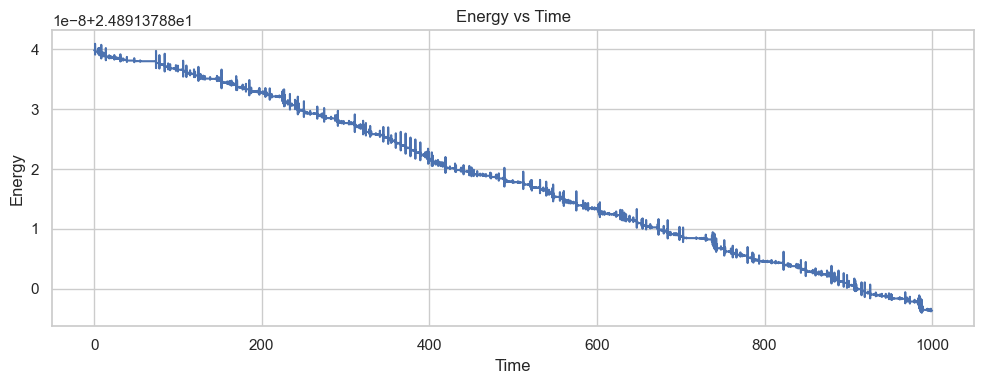

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


sns.set(style="whitegrid")

energy = traj_energy[:, 4]

plt.figure(figsize=(10, 4))
sns.lineplot(x=t, y=energy)

plt.xlabel("Time")
plt.ylabel("Energy")
plt.title("Energy vs Time")
plt.tight_layout()
plt.show()
